# Problem sheet 3.1

## Bayesian inference in 1d and 2d

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.table as t

### Data Loading

for this notebook we use 12 times the uncertainties of the lecture to exaggerate the effect

In [2]:
data=t.Table.read('xi_measurement.dat',format='ascii')
data['sigma(xi(theta))']=1.5

generate a diagonal covariance matrix for the given uncertainties assumming points are independent

In [3]:
covar=np.diag(data['sigma(xi(theta))']**2)
invcov=np.linalg.pinv(covar)

### A) Model and Prior

In [4]:
def model_earth(A,theta=data['theta[arcmin]']):
    A = np.atleast_1d(A) #make sure A is a numpy array and not a python scalar
    theta = np.atleast_1d(theta) #make sure theta is a numpy array and not a python scalar
    out = A[:,np.newaxis]*np.sqrt(theta[np.newaxis,:])
    return out

this is a prior function that accepts vectors of A, also in a logarithmic version

In [5]:
def prior_earth (A):
    A=np.atleast_1d(A) #make sure A is a numpy array and not a python scalar
    out = np.zeros(A.shape)
    out[(A>=0) & (A<=4)]=0.25
    return out

#we'll actually use this later on
def log_prior_earth (A):
    A=np.atleast_1d(A) #make sure A is a numpy array and not a python scalar
    out = -np.ones(A.shape)*np.inf # log(0)=-inf
    out[(A>=0) & (A<=4)]=np.log(0.25)
    return out

### B) Confidence Interval

Likelihood function $$\mathcal{L}=P(\mathrm{data|model})$$ and its log-version we assume a multivariate Gaussian model, i.e. $$\mathcal{L}=\frac{1}{\sqrt{(2\pi)^n det(C)}} \exp(-\frac{\Delta^T C^{-1} \Delta}{2})$$ with $$\Delta = \mathrm{data} - \mathrm{model}$$
we discard the normalization factors here, and normalize things later. Note that if covariances depend on the model parameters, i.e. $C=C(\mathrm{model})$, those normalization factors need to be taken into account properly.

In [6]:
def log_likelihood(parameters, data=data, invcov=invcov, model=model_earth):
    predictions = model(parameters,data['theta[arcmin]'])
    origshape = predictions.shape
    predictions.shape = (-1,predictions.shape[-1])
    Delta = data['xi(theta)'][np.newaxis,:]-predictions
    log_L = -0.5*np.einsum('ij,jk,ik->i',Delta,invcov,Delta)
    log_L.shape = origshape[:-1]
    #the line above does a vectorized version of Delta.dot(invcov).dot(Delta.T), 
    #i.e. when supplying multiple values for parameters at once it computes the log_L for each, 
    #the Einstein sum convention is followed, i.e. sum_{j,k} Delta(i,j)*C(j,k)*Delta(i,k) is computed for each value of i
    return log_L

compute the (unnormalized) likelihood

In [7]:
likelihood = lambda parameters, data=data, invcov=invcov, model=model_earth: np.exp(log_likelihood(parameters=parameters, invcov=invcov, data=data, model=model))

compute the posterior by multiplying with the prior and normalizing the integrated posterior to 1

In [8]:
def log_posterior(parameters, data=data, invcov=invcov, model=model_earth, log_prior=log_prior_earth):
    return log_likelihood(parameters, data=data, invcov=invcov, model=model) + log_prior(parameters)

def posterior(parameters, data=data, invcov=invcov, model=model_earth, log_prior=log_prior_earth):
    post=np.exp(log_posterior(parameters, data=data, invcov=invcov, model=model, log_prior=log_prior))
    post/=np.sum(post)   #this normalizes the sum to be one
    if len(parameters.shape)==1: #this is the 1d case
        post/=np.diff(parameters)[0] #this normalizes the integral to be one given equally spaced values for parameters
    elif len(parameters.shape)==3:
        A,n=parameters
        post/=A[0,1]-A[0,0]
        post/=n[1,0]-n[0,0]
    return post

evaluate the posterior on a grid of A values and grab the maximum a posteriori (MAP)

In [9]:
A_grid = np.linspace(-1e-8,5,30000)
post_earth = posterior(A_grid)
MAP_A_earth = A_grid[np.argmax(post_earth)]
max_like_A_earth = A_grid[np.argmax(likelihood(A_grid))]

compute the confidence interval

In [10]:
argsort_post_earth=np.argsort(post_earth)   #sort by posterior probability, makes evaluation easier
cumsum=np.cumsum(post_earth[argsort_post_earth])/np.sum(post_earth)   #for this part actually a normalization that normalizes the sum of all evaluated probabilities to 1 is more suitable
in_confidence_region = cumsum>=0.317 #this discards the lowest posterior probability points until a total of 31.7% of the probability is reached
A_in_confidence = A_grid[argsort_post_earth[in_confidence_region]]
A_in_confidence.sort()
A_min_earth,A_max_earth = A_in_confidence.min(), A_in_confidence.max()
print(f"lower end of confidence interval: {A_min_earth}, upper end: {A_max_earth}")

lower end of confidence interval: 2.256075197018901, upper end: 2.3475782473035767


plot the MAP model, the maximum likelihood model and the data (both models are the same here as the prior is flat)

Text(0, 0.5, '$\\xi(\\theta)$')

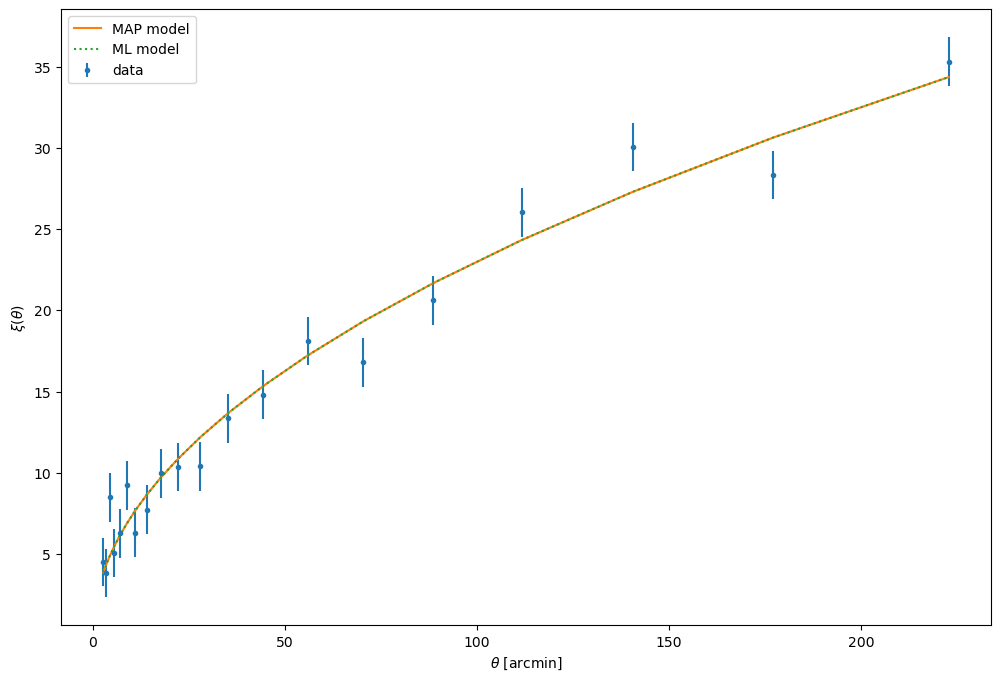

In [11]:
plt.figure(figsize=[12,8])

plt.errorbar(data['theta[arcmin]'],data['xi(theta)'],data['sigma(xi(theta))'],label='data',ls='',marker='.')
plt.plot(data['theta[arcmin]'],model_earth(MAP_A_earth).T,label='MAP model')
plt.plot(data['theta[arcmin]'],model_earth(max_like_A_earth).T,label='ML model',ls=':')
plt.legend()
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\xi(\theta)$')

plot the posterior and confidence interval

Text(0, 0.5, 'probability')

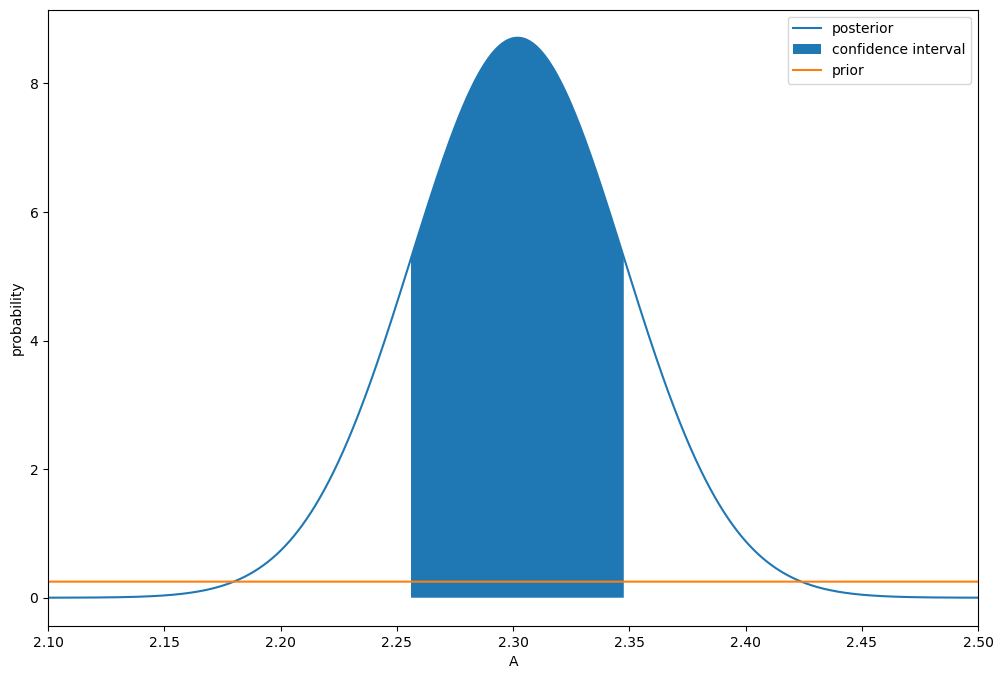

In [12]:
plt.figure(figsize=[12,8])

plt.plot(A_grid,post_earth,label='posterior')
selection = (A_grid>=A_min_earth) & (A_grid<=A_max_earth) 
plt.fill_between(A_grid[selection],np.zeros(np.sum(selection)), post_earth[selection],label='confidence interval')
plt.plot(A_grid,prior_earth(A_grid),label='prior')
plt.legend()
plt.xlim(2.1,2.5)
plt.xlabel('A')
plt.ylabel('probability')

### C) Vulkan

In [13]:
def model_vulkan(B,theta=data['theta[arcmin]']):
    B = np.atleast_1d(B) #make sure A is a numpy array and not a python scalar
    theta = np.atleast_1d(theta) #make sure theta is a numpy array and not a python scalar
    out = B[:,np.newaxis]**2*np.sqrt(theta[np.newaxis,:])
    return out

In [14]:
def prior_vulkan(B):
    B=np.atleast_1d(B) #make sure A is a numpy array and not a python scalar
    out = np.zeros(B.shape)
    out[(B>=0) & (B<=2)]=0.5
    return out
def log_prior_vulkan(B):
    B=np.atleast_1d(B) #make sure A is a numpy array and not a python scalar
    out = -np.ones(B.shape)*np.inf # log(0)=-inf
    out[(B>=0) & (B<=2)]=np.log(0.5)
    return out

In [15]:
B_grid = np.linspace(-1e-8,np.sqrt(5),30000)
post_vulkan = posterior(B_grid,log_prior=log_prior_vulkan,model=model_vulkan)
MAP_B_vulkan = B_grid[np.argmax(post_vulkan)]
max_like_B_vulkan = B_grid[np.argmax(likelihood(B_grid,model=model_vulkan))]

compute the confidence interval

In [16]:
argsort_post_vulkan=np.argsort(post_vulkan)   #sort by posterior probability, makes evaluation easier
cumsum=np.cumsum(post_vulkan[argsort_post_vulkan])/np.sum(post_vulkan)   #for this part actually a normalization that normalizes the sum of all evaluated probabilities to 1 is more suitable
in_confidence_region = cumsum>=0.317 #this discards the lowest posterior probability points until a total of 31.7% of the probability is reached
B_in_confidence = B_grid[argsort_post_vulkan[in_confidence_region]]
B_in_confidence.sort()
B_min_vulkan,B_max_vulkan = B_in_confidence.min(), B_in_confidence.max()
print(f"lower end of confidence interval: {B_min_vulkan}, upper end: {B_max_vulkan}")

lower end of confidence interval: 1.5020169244347568, upper end: 1.5322048485301405


plot the MAP model, the maximum likelihood model and the data (both models are the same here as the prior is flat)

Text(0, 0.5, '$\\xi_+(\\theta)$')

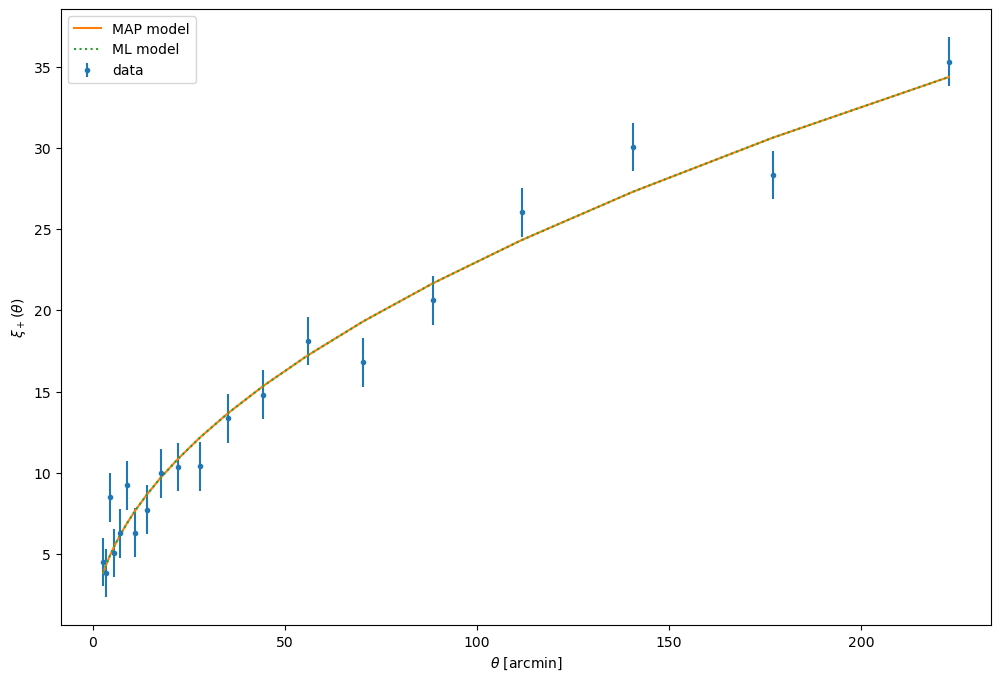

In [17]:
plt.figure(figsize=[12,8])

plt.errorbar(data['theta[arcmin]'],data['xi(theta)'],data['sigma(xi(theta))'],label='data',ls='',marker='.')
plt.plot(data['theta[arcmin]'],model_vulkan(MAP_B_vulkan).T,label='MAP model')
plt.plot(data['theta[arcmin]'],model_vulkan(max_like_B_vulkan).T,label='ML model',ls=':')
plt.legend()
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\xi_+(\theta)$')

plot the posterior and confidence interval

Text(0, 0.5, 'probability')

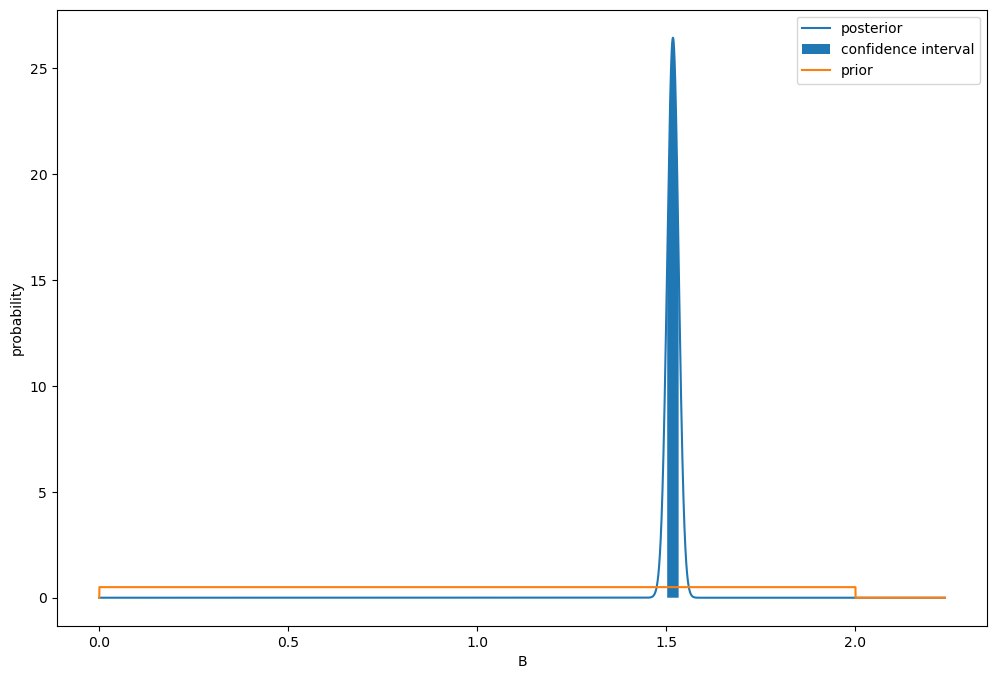

In [18]:
plt.figure(figsize=[12,8])

plt.plot(B_grid,post_vulkan,label='posterior')
selection = (B_grid>=B_min_vulkan) & (B_grid<=B_max_vulkan) 
plt.fill_between(B_grid[selection],np.zeros(np.sum(selection)), post_vulkan[selection],label='confidence interval')
plt.plot(B_grid,prior_vulkan(B_grid),label='prior')
plt.legend()
plt.xlabel('B')
plt.ylabel('probability')

### D) Earth vs Vulkan

compare the best fits obtained before under both models

Text(0, 0.5, '$\\xi_+(\\theta)$')

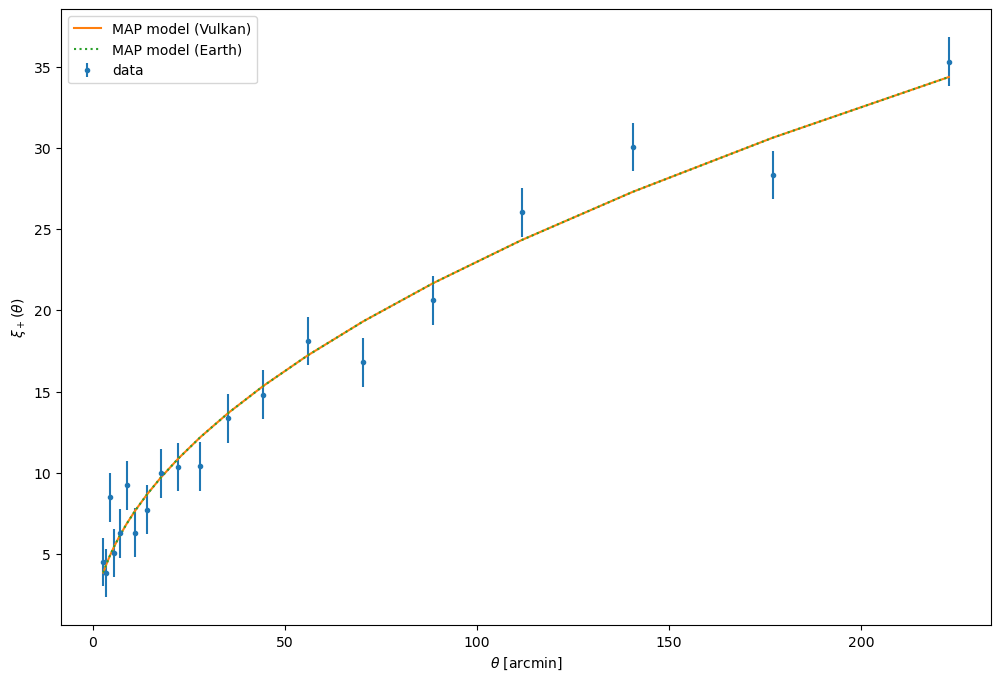

In [19]:
plt.figure(figsize=[12,8])

plt.errorbar(data['theta[arcmin]'],data['xi(theta)'],data['sigma(xi(theta))'],label='data',ls='',marker='.')
plt.plot(data['theta[arcmin]'],model_vulkan(MAP_B_vulkan).T,label='MAP model (Vulkan)')
plt.plot(data['theta[arcmin]'],model_earth(MAP_A_earth).T,label='MAP model (Earth)',ls=':')
plt.legend()
plt.xlabel(r'$\theta$ [arcmin]')
plt.ylabel(r'$\xi_+(\theta)$')

compare the posteriors in A, note that to get the right normalization of the posterior probability for the Vulkan analysis P(B) need to be multiplied with the Jacobian determinant, in this case: $$\frac{\mathrm{d}B}{\mathrm{d}A}=\frac{1}{2\sqrt{A}}=\frac{1}{2B}$$

Text(0, 0.5, 'Posterior probability')

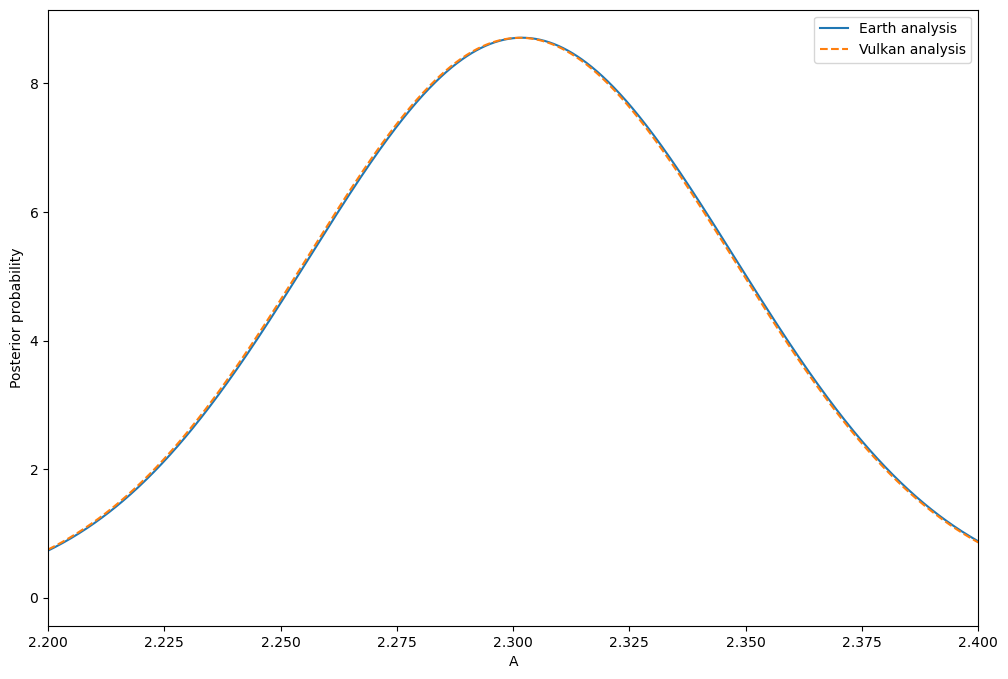

In [20]:
plt.figure(figsize=[12,8])

plt.plot(A_grid,post_earth,label='Earth analysis')
plt.plot((B_grid**2)[B_grid>1e-1],post_vulkan[B_grid>1e-1]*1/2/B_grid[B_grid>1e-1],label='Vulkan analysis',ls='--')
plt.legend()
plt.xlabel('A')
plt.xlim(2.2,2.4)
plt.ylabel('Posterior probability')

Reason: both analyses use different priors on A, while the Earth analysis one is flat, the prior in the Vulkan analysis is not. It is: $$P_{Vulkan}(A)=P_{Vulkan}(B)\frac{\mathrm{d}B}{\mathrm{d}A} = \frac{P_{Vulkan}(\sqrt{A})}{2\sqrt{A}}\; \mathrm{for} A\in [0,4]$$ so in the Vulkan analysis lower values for A will have the same likelihood, but higher prior and therefore also posterior probability

### E) 2d inference

In [21]:
def model_2d(params,theta=data['theta[arcmin]']):
    A,n=params
    theta = np.atleast_1d(theta) #make sure theta is a numpy array and not a python scalar
    out = A[...,np.newaxis]*theta[np.newaxis,np.newaxis,:]**n[...,np.newaxis]
    return out
def prior_2d (params):
    A,n=params
    out = np.zeros(A.shape)
    out[(A>=0) & (A<=4) & (n>=0)& (n<=1)]=0.25
    return out

def log_prior_2d (params):
    A,n=params
    out = -np.ones(A.shape)*np.inf
    out[(A>=0) & (A<=4) & (n>=0)& (n<=1)]=np.log(0.25)
    return out

In [22]:
#generate grids for both parameters
n_grid_2d = np.linspace(-0.1,1.1,100)
A_grid_2d = np.linspace(-0.1,4.1,100)
params_2d=np.array(np.meshgrid(A_grid_2d,n_grid_2d))
#use the original dataset here without inflated errors
data_2d=t.Table.read('xi_measurement.dat',format='ascii')
covar_2d=np.diag(data_2d['sigma(xi(theta))']**2)
invcov_2d=np.linalg.pinv(covar_2d)
post_2d=posterior(params_2d,model=model_2d,log_prior=log_prior_2d,data=data_2d,invcov=invcov_2d)

### F) Contours

In [23]:
post_2d_flat = post_2d.flatten()
argsort_post_2d = np.argsort(post_2d_flat)   #sort by posterior probability, makes evaluation easier
cumsum_2d = np.cumsum(post_2d_flat[argsort_post_2d]/np.sum(post_2d))   #for this part actually a normalization that normalizes the sum of all evaluated probabilities to 1 is more suitable

in_confidence_region = cumsum_2d>=0.317 #this discards the lowest posterior probability points until a total of 31.7% of the probability is reached
level68=post_2d_flat[argsort_post_2d[in_confidence_region]].min()


in_confidence_region = cumsum_2d>=0.05 #this discards the lowest posterior probability points until a total of 95% of the probability is reached
level95=post_2d_flat[argsort_post_2d[in_confidence_region]].min()

plot the 68% and 95% contours, note that those are not the same as the 1-sigma and 2-sigma contours of an n-dimensional Gaussian (although often named that way anyway)

(0.15, 0.6)

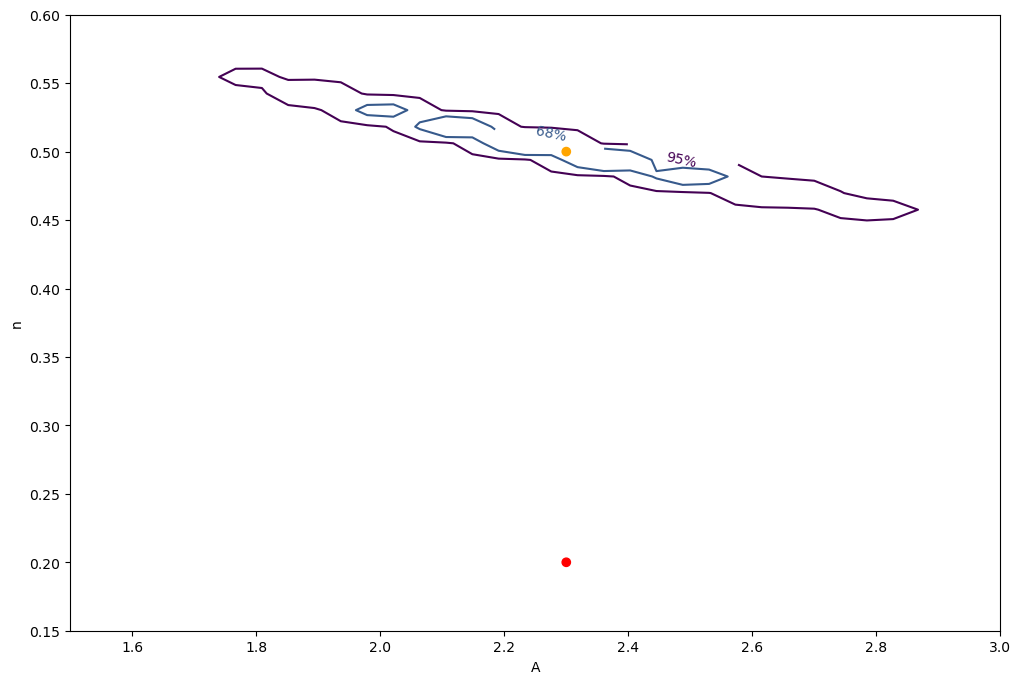

In [24]:
plt.figure(figsize=[12,8])
Contours=plt.contour(A_grid_2d,n_grid_2d,post_2d,levels=[level95,level68,post_2d.max()])
#this is just for string labels
fmt = {}
strs = ['95%','68%']
for l, s in zip(Contours.levels, strs):
    fmt[l] = s
plt.clabel(Contours, Contours.levels, inline=True, fmt=fmt, fontsize=10)
plt.xlabel('A')
plt.ylabel('n')
plt.scatter([2.3,2.3],[0.2,0.5],color=['red','orange'])
plt.xlim(1.5,3)
plt.ylim(0.15,0.6)